# MDSBD - APBD: Trabajo Final. 
_Jerónimo Carranza Carranza._ 

<a id=0 ></a>
## Índice

1. [Formulación del problema](#1)  
2. [Sesión Spark](#2)  
3. [Librerías](#3)  
4. [Pre-procesado](#4)  
4.1. [Lectura de datos](#4_1)  
4.2. [Exploración de datos](#4_2)  
4.2.1. [Dimensiones, cabecera, estructura](#4_2_1)  
4.2.2. [Resumen estadístico](#4_2_2)  
4.2.3. [Datos faltantes](#4_2_3)  
4.2.3.1. [LotFrontage](#4_2_3_1)  
4.2.3.2. [Variables relacionadas con Garage](#4_2_3_2)  
4.2.3.3. [Variables relacionadas con revestimientos exteriores](#4_2_3_3)  
4.2.3.4. [Electrical](#4_2_3_4)  
4.2.3.5. [Variables relacionadas con sótanos (Bsmt%)](#4_2_3_5)  
4.2.3.6. [Variables relacionadas con baños (%Bath)](#4_2_3_6)  
4.2.3.7. [Otras variables](#4_2_3_7)  
4.2.4. [Imputación de datos](#4_2_4)  
4.3. [Conversión de datos](#4_3)  
5. [Componentes principales](#5)   
6. [Modelos de regresión](#6)   
6.1. [Conjuntos de entrenamiento y validación](#6_1)   
6.2. [Random Forest](#6_2)   
6.3. [Regresión lineal](#6_3)   
6.4. [Evaluación de modelos](#6_4)   
6.5. [Subida a Kaggle](#6_5)   
7. [Stop spark](#7)   


<a id=1 ></a>
## 1. Formulación del problema
[Ir a Índice](#0)

El objetivo de este trabajo es practicar con las diferentes herramientas que Spark nos proporciona para el procesamiento distribuido de grandes cantidades de datos. 

Se utilizarán datos de aprendizaje de Kaggle, concretamente los relativos al problema de predicción del precio de venta de viviendas (Ames, Iowa) en función de una serie de características de los inmuebles y de su entorno (79 variables predictoras).

La solución al problema empezará con el preprocesado, donde prepararemos el dataset para luego poder aplicar modelos y ajuste de parámetros. Dadas las caracterı́sticas del dataset, en el preprocesado como mı́nimo tendremos que procesar missings y convertir variables a tipo numérico. Otras tareas interesantes pueden ser selección de variables (correlaciones, importancia de variables, etc), reducción de dimensionalidad, conversión de categóricas a oneHot, etc.

Con respecto a la parte de análisis se deben probar varios modelos y ajustar sus parámetros mediante validación cruzada. La evaluación del modelo final debe hacerse con un dataset diferente al de entrenamiento. Se recomienda automatizar procesos mediante el uso de pipelines y creación de funciones para evitar repetir código.

La métrica a usar para la evaluación de soluciones es RMSLE. Esta métrica no se encuentra dentro de las que ofrece el objeto RegressionEvaluator por lo que debemos definir nuestro propio evaluador o bien calcularla a mano.



<a id=2 ></a>
## 2. Sesión Spark
[Ir a Índice](#0)

In [709]:
import sys

# Añade la ruta de tu carpeta Spark.
spark_path = '$SPARK_HOME/spark-2.1.0-bin-hadoop2.7'

sys.path.append(spark_path + '/python')
sys.path.append(spark_path + '/python/lib/py4j-0.10.4-src.zip')

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("APBD_TF").getOrCreate()

spark

- Nuestro SparkContext sigue presente como parte de SparkSession.

In [710]:
spark.sparkContext.defaultParallelism

2

<a id=3 ></a>
## 3. Librerías
[Ir a Índice](#0)

In [711]:
import pandas as pd
import numpy as np

from math import sqrt
from time import time

from numpy.linalg import *

from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.window import *

from pyspark.ml import Pipeline
from pyspark.ml.feature import *
from pyspark.ml.regression import *
from pyspark.ml.evaluation import *
from pyspark.ml.tuning import *

from pyspark.mllib.stat import *
from pyspark.mllib.linalg import *

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot')

from plotnine import *  
from plotnine.data import *


In [712]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 20)
pd.set_option('precision', 4)

<a id=4 ></a>
## 4. Pre-procesado
<a id=4_1 ></a>
### 4.1. Lectura de los datos
[Ir a Índice](#0)

- Dataset de Kaggle _Ames Housing_ con información de las características y precios de venta de viviendas en Ames, Iowa.
- Hay 79 variables y se trata de predecir los precios de venta de las viviendas.
- Aunque están descargados train.csv y test.csv, este último no puede utilizarse en la evaluación local (sólo contra kaggle), así que habrá que utilizar un muestreo de train.csv para para formar el verdadero conjunto de entrenamiento y el conjunto de test en local.
- Junto a los datos existe un fichero _description.txt_ que describe el significado de las variables.


In [713]:
train = spark.read.csv(path='./train.csv', header=True, inferSchema=True, nullValue='NA')
test = spark.read.csv(path='./test.csv', header=True, inferSchema=True, nullValue='NA')

Se ha hecho la lectura de los datos con 'NA' como indicativo de valor nulo, sin embargo, de la lectura del fichero de metadatos _description.txt_ se comprueba que existen algunas variables en las que 'NA' se contempla como una posibilidad más entre otras opciones, en algunos casos porque existe dependencia de otra variable. No son por tanto datos faltantes o valores desconocidos, como vemos seguidamente:

    PoolQC: Pool quality
      Ex	Excellent
      Gd	Good
      TA	Average/Typical
      Fa	Fair
      NA	No Pool
    
    MiscFeature: Miscellaneous feature not covered in other categories  
      Elev	Elevator
      Gar2	2nd Garage (if not described in garage section)
      Othr	Other
      Shed	Shed (over 100 SF)
      TenC	Tennis Court
      NA	None		

    Alley: Type of alley access to propert  
      Grvl	Gravel
      Pave	Paved
      NA 	No alley access

    Fence: Fence quality  
      GdPrv	Good Privacy
      MnPrv	Minimum Privacy
      GdWo	Good Wood
      MnWw	Minimum Wood/Wire
      NA	No Fence

    FireplaceQu: Fireplace quality  
      Ex	Excellent - Exceptional Masonry Fireplace
      Gd	Good - Masonry Fireplace in main level
      TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
      Fa	Fair - Prefabricated Fireplace in basement
      Po	Poor - Ben Franklin Stove
      NA	No Fireplace

    BsmtQual: Evaluates the height of the basement  
      Ex	Excellent (100+ inches)	
      Gd	Good (90-99 inches)
      TA	Typical (80-89 inches)
      Fa	Fair (70-79 inches)
      Po	Poor (<70 inches
      NA	No Basement
		
    BsmtCond: Evaluates the general condition of the basement  
       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement
	
    BsmtExposure: Refers to walkout or garden level walls  
       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
	
    BsmtFinType1: Rating of basement finished area  
       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

    GarageType: Garage location  
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage
			
    GarageFinish: Interior finish of the garage  
       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage
		
    GarageQual: Garage quality  
       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
		
    GarageCond: Garage condition  
       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage


Teniendo en cuenta lo dicho, se va a proceder a la recodificación de los datos NA de estas variables a otro valor para ser tratados como datos válidos.


In [714]:
vars_recoding_NA={
    'PoolQC':'NoPool',
    'MiscFeature':'None',
    'Alley':'NoAlleyAccess',
    'Fence':'NoFence',
    'FireplaceQu':'NoFireplace',
    'BsmtQual':'NoBasement',
    'BsmtCond':'NoBasement',
    'BsmtExposure':'NoBasement',
    'BsmtFinType1':'NoBasement',
    'BsmtFinType2':'NoBasement',
    'GarageType': 'NoGarage',
    'GarageFinish':'NoGarage',
    'GarageQual':'NoGarage',
    'GarageCond':'NoGarage',
}

In [715]:
train = train.fillna(vars_recoding_NA)

In [716]:
test = test.fillna(vars_recoding_NA)

Comprobamos:

In [717]:
train.createOrReplaceTempView('train_view')
test.createOrReplaceTempView('test_view')

In [718]:
spark.sql('SELECT PoolQC FROM train_view WHERE PoolQC is null').show()

+------+
|PoolQC|
+------+
+------+



<a id=4_2 ></a>
### 4.2. Análisis exploratorio 
[Ir a Índice](#0)

<a id=4_2_1 ></a>
#### 4.2.1. Dimensiones, esquemas
[Ir a Índice](#0)

- Dimensiones conjunto train

In [719]:
# Dimensiones conjunto train
train.count(), len(train.columns)

(1460, 81)

- Dimensiones conjunto test

In [720]:
# Dimensiones conjunto test
test.count(), len(test.columns)

(1459, 80)

- Listado de variables y tipos de dato (temporalmente se vinculan tipos de las del conjunto test)

In [721]:
variables = pd.DataFrame([(train.schema[i].dataType.typeName(), 
                           train.schema[i].nullable) for i in train.columns],
                        columns=('type','nullable'),
                        index=[train.columns])

vars_test = pd.DataFrame([(test.schema[i].dataType.typeName(), 
                           test.schema[i].nullable) for i in test.columns],
                        columns=('type','nullable'),
                        index=[test.columns])

variables.join(vars_test, rsuffix='_test')

,type,nullable,type_test,nullable_test
Id,integer,True,integer,True
MSSubClass,integer,True,integer,True
MSZoning,string,True,string,True
LotFrontage,integer,True,integer,True
LotArea,integer,True,integer,True
Street,string,True,string,True
Alley,string,False,string,False
LotShape,string,True,string,True
LandContour,string,True,string,True
Utilities,string,True,string,True


- Distribución de variables por tipo y posibilidad de nulos

In [722]:
pd.crosstab(variables.type, variables.nullable, margins=True)

nullable,False,True,All
type,,,
integer,0,38,38
string,14,29,43
All,14,67,81


<a id=4_2_2 ></a>
#### 4.2.1. Resumen estadístico
[Ir a Índice](#0)

Calculamos estadística básica de las variables tanto en train como en test y presentamos juntos.

In [723]:
train_summary = train.describe().toPandas().set_index('summary')
test_summary = test.describe().toPandas().set_index('summary')

ames_summary = pd.concat([train_summary, test_summary], axis=0).apply(pd.to_numeric,errors='ignore')
ames_summary

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,Id,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SalePrice,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
summary,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
count,1460.0000,1460.0000,1460.0000,1460,1460.0000,1460,1460,1460,1460.0000,1460.0000,1460,1460,1460.0000,1460.0000,1460,1460.0000,1460,1460,1460,1459,1460.0000,1460,1460,1460,1460,1460,1460,1460.0000,1460,1460.0000,1460,1460.0000,1460.0000,1460,1460,1460,1460,1379.0000,1460.0000,1460.0000,1460,1460,1460,1460.0000,1460.0000,1460,1460,1460,1460.0000,1460,1201.0000,1460,1460.0000,1460.0000,1460,1452.0000,1452,1460,1460.0000,1460.0000,1460,1460.0000,1460.0000,1460.0000,1460,1460.0000,1460,1460,1460,1460,1460.0000,1460,1460.0000,1460,1460.0000,1460.0000,1460,1460.0000,1460.0000,1460.0000,1460.0000
mean,1162.6267,346.9925,3.4096,None,2.8664,None,None,None,443.6397,46.5493,None,None,0.4253,0.0575,None,567.2404,None,None,None,None,21.9541,None,None,None,None,None,None,0.6130,None,1.5651,None,472.9801,1.7671,None,None,None,None,1978.5062,1515.4637,0.3829,None,None,None,730.5000,1.0466,None,None,None,10516.8281,None,70.0500,None,5.8445,56.8973,None,103.6853,None,None,43.4890,6.3219,None,46.6603,5.5753,6.0993,None,2.7589,None,None,None,None,180921.1959,None,15.0610,None,6.5178,1057.4295,None,94.2445,1971.2678,1984.8658,2007.8158
stddev,386.5877,436.5284,29.3173,None,0.8158,None,None,None,456.0981,161.3193,None,None,0.5189,0.2388,None,441.8670,None,None,None,None,61.1191,None,None,None,None,None,None,0.6447,None,0.5509,None,213.8048,0.7473,None,None,None,None,24.6897,525.4804,0.5029,None,None,None,421.6100,0.2203,None,None,None,9981.2649,None,24.2848,None,48.6231,42.3006,None,181.0662,None,None,496.1230,2.7036,None,66.2560,1.1128,1.3830,None,40.1773,None,None,None,None,79442.5029,None,55.7574,None,1.6254,438.7053,None,125.3388,30.2029,20.6454,1.3281
min,334.0000,0.0000,0.0000,Grvl,0.0000,1Fam,Fa,Av,0.0000,0.0000,ALQ,ALQ,0.0000,0.0000,Ex,0.0000,N,Artery,Artery,FuseA,0.0000,Ex,Ex,AsbShng,AsbShng,GdPrv,Ex,0.0000,BrkTil,0.0000,Maj1,0.0000,0.0000,Ex,Fin,Ex,2Types,1900.0000,334.0000,0.0000,Floor,Ex,1.5Fin,1.0000,0.0000,Ex,Bnk,Gtl,1300.0000,Corner,21.0000,IR1,0.0000,20.0000,C (all),0.0000,BrkCmn,Gar2,0.0000,1.0000,Blmngtn,0.0000,1.0000,1.0000,N,0.0000,Ex,ClyTile,Flat,Abnorml,34900.0000,COD,0.0000,Grvl,2.0000,0.0000,AllPub,0.0000,1872.0000,1950.0000,2006.0000
max,4692.0000,2065.0000,508.0000,Pave,8.0000,TwnhsE,TA,NoBasement,5644.0000,1474.0000,Unf,Unf,3.0000,2.0000,TA,2336.0000,Y,RRNn,RRNn,SBrkr,552.0000,TA,TA,WdShing,Wd Shng,NoFence,TA,3.0000,Wood,3.0000,Typ,1418.0000,4.0000,TA,Unf,TA,NoGarage,2010.0000,5642.0000,2.0000,Wall,TA,SLvl,1460.0000,3.0000,TA,Lvl,Sev,215245.0000,Inside,313.0000,Reg,572.0000,190.0000,RM,1600.0000,Stone,TenC,15500.0000,12.0000,Veenker,547.0000,9.0000,10.0000,Y,738.0000,NoPool,WdShngl,Shed,Partial,755000.0000,WD,480.0000,Pave,14.0000,6110.0000,NoSeWa,857.0000,2010.0000,2010.0000,2010.0000
count,1459.0000,1459.0000,1459.0000,1459,1459.0000,1459,1459,1459,1458.0000,1458.0000,1459,1459,1457.0000,1457.0000,1459,1458.0000,1459,1459,1459,1459,1459.0000,1459,1459,1458,1458,1459,1459,1459.0000,1459,1459.0000,1457,1458.0000,1458.0000,1459,1459,1459,1459,1381.0000,1459.0000,1459.0000,1459,1459,1459,1459.

Se trasponen DFs de resumen estadístico de variables y se incorporan variables Conjunto y Faltan para el estudio de datos faltantes.


In [724]:
train_summary_t = variables.join(train_summary.T).apply(pd.to_numeric,errors='ignore')
train_summary_t['Conjunto'] = 'train'
train_summary_t['Faltan'] = 1460 - train_summary_t['count']

test_summary_t = variables.join(test_summary.T).apply(pd.to_numeric,errors='ignore')
test_summary_t['Conjunto'] = 'test'
test_summary_t['Faltan'] = 1459 - test_summary_t['count']

ames_summary_t = pd.concat([train_summary_t, test_summary_t], axis=0)

In [725]:
ames_summary_t.reset_index(inplace=True)
ames_summary_t.rename(columns={'index':'varname'},inplace=True)
ames_summary_t

,varname,type,nullable,count,mean,stddev,min,max,Conjunto,Faltan
0,Id,integer,True,1460.0,730.5000,421.6100,1,1460,train,0.0
1,MSSubClass,integer,True,1460.0,56.8973,42.3006,20,190,train,0.0
2,MSZoning,string,True,1460.0,NaN,NaN,C (all),RM,train,0.0
3,LotFrontage,integer,True,1201.0,70.0500,24.2848,21,313,train,259.0
4,LotArea,integer,True,1460.0,10516.8281,9981.2649,1300,215245,train,0.0
5,Street,string,True,1460.0,NaN,NaN,Grvl,Pave,train,0.0
6,Alley,string,False,1460.0,NaN,NaN,Grvl,Pave,train,0.0
7,LotShape,string,True,1460.0,NaN,NaN,IR1,Reg,train,0.0
8,LandContour,string,True,1460.0,NaN,NaN,Bnk,Lvl,train,0.0
9,Utilities,string,True,1460.0,NaN,NaN,AllPub,NoSeWa,train,0.0


<a id=4_2_3 ></a>
#### 4.2.3. Datos faltantes
[Ir a Índice](#0)

In [726]:
vars_completas = ames_summary_t[ames_summary_t['Faltan']==0]
vars_incompletas = ames_summary_t[ames_summary_t['Faltan']>0]

print("variables con casos completos (train,test):")
len(vars_completas[vars_completas['Conjunto']=='train']), len(vars_completas[vars_completas['Conjunto']=='test'])

variables con casos completos (train,test):


(76, 61)

In [727]:
print("variables con casos incompletos (train,test,global):")
len(vars_incompletas[vars_incompletas.Conjunto=='train']), \
len(vars_incompletas[vars_incompletas.Conjunto=='test']), \
len(vars_incompletas.drop_duplicates(subset='varname'))


variables con casos incompletos (train,test,global):


(5, 19, 20)

In [728]:
data = vars_incompletas.sort_values('Faltan',ascending=False)[['varname','Conjunto','Faltan']]

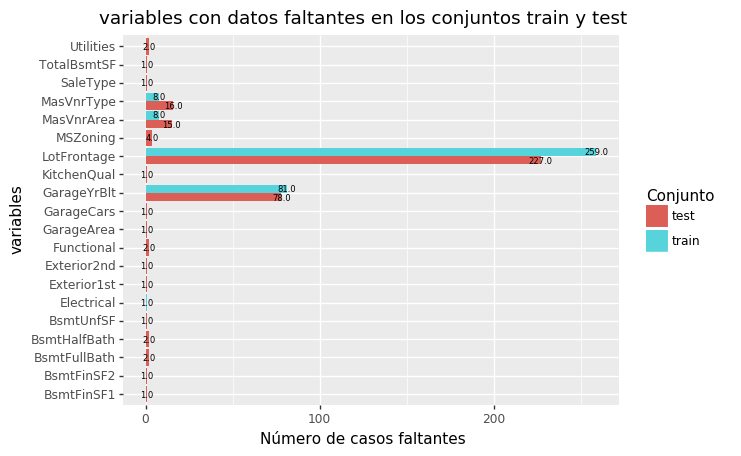

<ggplot: (8764428608818)>

In [729]:
g = (ggplot(data) + aes(x='varname', y='Faltan', fill='Conjunto') +
        geom_col(position='dodge') +
        geom_text(aes(label='Faltan'), size=6, position = position_dodge(width = 1)) +
        labs(x='variables', y="Número de casos faltantes") +
        coord_flip() +
        ggtitle('variables con datos faltantes en los conjuntos train y test')
     )
g

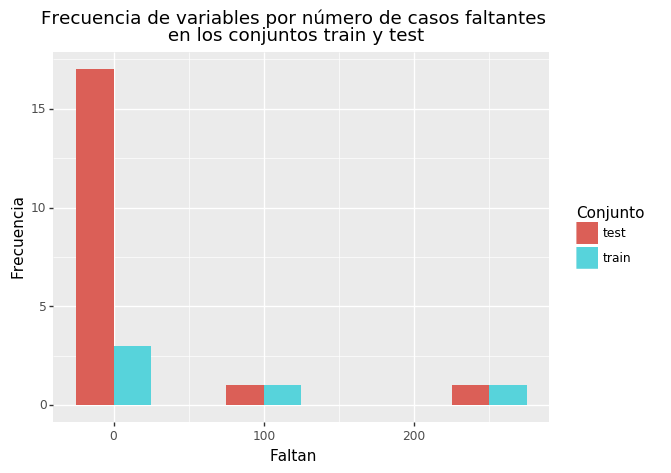

<ggplot: (-9223363272426542199)>

In [730]:
g = (ggplot(data) + aes(x='Faltan', fill='Conjunto') +
        geom_histogram(binwidth=50, position='dodge') +
        labs(y='Frecuencia') +
        ggtitle('Frecuencia de variables por número de casos faltantes\n en los conjuntos train y test')
     )
g

Se aprecia un desequilibrio a favor del conjunto test del número de varibles con pocos datos faltantes, equilibrándose para frecuencias más elevadas.

- Listado de variables con datos faltantes en los conjuntos train y test con resumen estadístico básico

In [731]:
vars_data_miss = data.pivot_table(index='varname', columns='Conjunto', values='Faltan',
                 fill_value=0).sort_values('train', ascending=False)

In [732]:
vars_data_miss.join(ames_summary.T)

,test,train,count,mean,stddev,min,max,count,mean,stddev,min,max
varname,,,,,,,,,,,,
LotFrontage,227,259,1201,70.05,24.28,21,313,1232,68.58,22.38,21,200
GarageYrBlt,78,81,1379,1979,24.69,1900,2010,1381,1978,26.43,1895,2207
MasVnrType,16,8,1452,None,None,BrkCmn,Stone,1443,None,None,BrkCmn,Stone
MasVnrArea,15,8,1452,103.7,181.1,0,1600,1444,100.7,177.6,0,1290
Electrical,0,1,1459,None,None,FuseA,SBrkr,1459,None,None,FuseA,SBrkr
BsmtFinSF1,1,0,1460,443.6,456.1,0,5644,1458,439.2,455.3,0,4010
TotalBsmtSF,1,0,1460,1057,438.7,0,6110,1458,1046,442.9,0,5095
SaleType,1,0,1460,None,None,COD,WD,1458,None,None,COD,WD
MSZoning,4,0,1460,None,None,C (all),RM,1455,None,None,C (all),RM


<a id=4_2_3_1 ></a>
##### LotFrontage
[Ir a Índice](#0)

Se utilizará la mediana para la imputación de los valores faltantes. Para calcularla se utilizará el método _approxQuantile_.


In [733]:
impute_train = {'LotFrontage': train.approxQuantile('LotFrontage',[0.5],0)[0]}
impute_test = {'LotFrontage': test.approxQuantile('LotFrontage',[0.5],0)[0]}
impute_train, impute_test

({'LotFrontage': 70.0}, {'LotFrontage': 67.0})

<a id=4_2_3_2 ></a>
##### Variables relacionadas con Garage
[Ir a Índice](#0)

Las variables que se estudian para posible imputación de valores faltantes son: GarageYrBlt, GarageCars y GarageArea.

La variable GarageYrBlt hace referencia al año de construcción del garage. El rango en train es razonable, pero no lo es en test donde el máximo, 2207, es claramente erróneo. Otras variables temporales o vinculadas que pueden contribuir a aclarar las situaciones de error o falta del dato son: GarageType, YearBuilt, YearRemodAdd.

Las variables GarageCars y GarageArea se refieren a la capacidad en número de coches y al área.

In [734]:
spark.sql('SELECT GarageYrBlt,GarageType,YearBuilt,YearRemodAdd FROM train_view WHERE GarageYrBlt is null').show(5)

+-----------+----------+---------+------------+
|GarageYrBlt|GarageType|YearBuilt|YearRemodAdd|
+-----------+----------+---------+------------+
|       null|  NoGarage|     1955|        1955|
|       null|  NoGarage|     1920|        2008|
|       null|  NoGarage|     1968|        1968|
|       null|  NoGarage|     1915|        1982|
|       null|  NoGarage|     1994|        1995|
+-----------+----------+---------+------------+
only showing top 5 rows



In [735]:
spark.sql('SELECT GarageYrBlt,GarageType,YearBuilt,YearRemodAdd \
          FROM train_view WHERE GarageYrBlt is null and GarageType <> "NoGarage"').show()

+-----------+----------+---------+------------+
|GarageYrBlt|GarageType|YearBuilt|YearRemodAdd|
+-----------+----------+---------+------------+
+-----------+----------+---------+------------+



Todos los nulos de train corresponden realmente a que no existe garage. Se imputará el valor 0 en estos casos.


In [736]:
spark.sql('SELECT GarageYrBlt,GarageType,YearBuilt,YearRemodAdd \
          FROM test_view WHERE GarageYrBlt is null and GarageType <> "NoGarage"').show()

+-----------+----------+---------+------------+
|GarageYrBlt|GarageType|YearBuilt|YearRemodAdd|
+-----------+----------+---------+------------+
|       null|    Detchd|     1910|        1983|
|       null|    Detchd|     1923|        1999|
+-----------+----------+---------+------------+



In [737]:
spark.sql('SELECT COUNT(GarageType) \
          FROM test_view WHERE GarageYrBlt is not null and GarageType == "Detchd"').show()

+-----------------+
|count(GarageType)|
+-----------------+
|              390|
+-----------------+



In [738]:
spark.sql('SELECT COUNT(GarageType) \
          FROM test_view \
          WHERE (GarageYrBlt == YearBuilt or GarageYrBlt == YearRemodAdd) and GarageType == "Detchd"').show()

+-----------------+
|count(GarageType)|
+-----------------+
|              214|
+-----------------+



In [739]:
spark.sql('SELECT COUNT(GarageType) \
          FROM test_view \
          WHERE GarageYrBlt == YearBuilt and GarageType == "Detchd"').show()

+-----------------+
|count(GarageType)|
+-----------------+
|              203|
+-----------------+



In [740]:
spark.sql('SELECT GarageYrBlt,GarageType,YearBuilt,YearRemodAdd \
          FROM test_view WHERE GarageYrBlt = 2207').show()

+-----------+----------+---------+------------+
|GarageYrBlt|GarageType|YearBuilt|YearRemodAdd|
+-----------+----------+---------+------------+
|       2207|    Attchd|     2006|        2007|
+-----------+----------+---------+------------+



In [741]:
spark.sql('SELECT * FROM test_view WHERE GarageCars is null or GarageArea is null').toPandas()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,2577,70,RM,50,9060,Pave,NoAlleyAccess,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0,TA,TA,BrkTil,Gd,TA,No,ALQ,548,Unf,0,311,859,GasA,Ex,Y,SBrkr,942,886,0,1828,0,0,2,0,3,1,Gd,6,Typ,0,NoFireplace,Detchd,None,NoGarage,None,None,NoGarage,NoGarage,Y,174,0,212,0,0,0,NoPool,MnPrv,None,0,3,2007,WD,Alloca


Los nulos de GarageYrBlt en test corresponden a garages que están aparte de la vivienda. Se imputará el mismo valor de la variable YearBuilt (Año de construcción de la vivienda) que dentro de este tipo de garage es el año más frequente entre las variables temporales disponibles.

Con respecto al valor GarageYrBlt=2207 vemos claramente que debería ser 2007. 

Por último las variables GarageCars y GarageArea aparecen nulas en un caso que no tiene garage, por lo que se imputarán ambas a 0.

In [742]:
impute_train['GarageYrBlt'] = 0

In [743]:
# Recordatorio
impute_test['GarageYrBlt'] = '= test.YearBuilt'

In [744]:
impute_test['GarageCars'] = 0
impute_test['GarageArea'] = 0

<a id=4_2_3_3 ></a>
##### Variables relacionadas con revestimientos exteriores
[Ir a Índice](#0)

Se analizan los datos nulos de las siguientes variables: Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, que hacen referencia a los tipos de recubrimientos exteriores y superficie del revestimiento exterior de albañilería.


In [745]:
# En train sólo aparecen MasVnrType y MasVnrArea con datos faltantes
spark.sql('SELECT * \
          FROM train_view WHERE MasVnrType is null').toPandas()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,235,60,RL,NaN,7851,Pave,NoAlleyAccess,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,None,None,Gd,TA,PConc,Gd,TA,No,GLQ,625,Unf,0,235,860,GasA,Ex,Y,SBrkr,860,1100,0,1960,1,0,2,1,4,1,Gd,8,Typ,2,TA,BuiltIn,2002,Fin,2,440,TA,TA,Y,288,48,0,0,0,0,NoPool,NoFence,None,0,5,2010,WD,Normal,216500
1,530,20,RL,NaN,32668,Pave,NoAlleyAccess,IR1,Lvl,AllPub,CulDSac,Gtl,Crawfor,Norm,Norm,1Fam,1Story,6,3,1957,1975,Hip,CompShg,Wd Sdng,Stone,None,None,Gd,TA,PConc,TA,TA,No,Rec,1219,Unf,0,816,2035,GasA,TA,Y,SBrkr,2515,0,0,2515,1,0,3,0,4,2,TA,9,Maj1,2,TA,Attchd,1975,RFn,2,484,TA,TA,Y,0,0,200,0,0,0,NoPool,NoFence,None,0,3,2007,WD,Alloca,200624
2,651,60,FV,65.0,8125,Pave,NoAlleyAccess,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,6,2007,2007,Gable,CompShg,CemntBd,CmentBd,None,None,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,813,813,GasA,Ex,Y,SBrkr,822,843,0,1665,0,0,2,1,3,1,Gd,7,Typ,0,NoFireplace,Attchd,2007,RFn,2,562,TA,TA,Y,0,0,0,0,0,0,NoPool,NoFence,None,0,5,2008,WD,Normal,205950
3,937,20,RL,67.0,10083,Pave,NoAlleyAccess,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,None,None,Gd,TA,PConc,Gd,TA,No,GLQ,833,Unf,0,343,1176,GasA,Ex,Y,SBrkr,1200,0,0,1200,1,0,2,0,2,1,Gd,5,Typ,0,NoFireplace,Attchd,2003,RFn,2,555,TA,TA,Y,0,41,0,0,0,0,NoPool,NoFence,None,0,8,2009,WD,Normal,184900
4,974,20,FV,95.0,11639,Pave,NoAlleyAccess,Reg,Lvl,AllPub,Corner,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,5,2007,2008,Gable,CompShg,CemntBd,CmentBd,None,None,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1428,1428,GasA,Ex,Y,SBrkr,1428,0,0,1428,0,0,2,0,3,1,Gd,6,Typ,0,NoFireplace,Attchd,2007,Fin,2,480,TA,TA,Y,0,120,0,0,0,0,NoPool,NoFence,None,0,12,2008,New,Partial,182000
5,978,120,FV,35.0,4274,Pave,Pave,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,TwnhsE,1Story,7,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,None,Gd,TA,PConc,Gd,TA,No,GLQ,1106,Unf,0,135,1241,GasA,Ex,Y,SBrkr,1241,0,0,1241,1,0,1,1,1,1,Gd,4,Typ,0,NoFireplace,Attchd,2007,Fin,2,569,TA,TA,Y,0,116,0,0,0,0,NoPool,NoFence,None,0,11,2007,New,Partial,199900
6,1244,20,RL,107.0,13891,Pave,NoAlleyAccess,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,None,Ex,TA,PConc,Ex,Gd,Gd,GLQ,1386,Unf,0,690,2076,GasA,Ex,Y,SBrkr,2076,0,0,2076,1,0,2,1,2,1,Ex,7,Typ,1,Gd,Attchd,2006,Fin,3,850,TA,TA,Y,216,229,0,0,0,0,NoPool,NoFence,None,0,9,2006,New,Partial,465000
7,1279,60,RL,75.0,9473,Pave,NoAlleyAccess,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,8,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,None,None,Gd,TA,PConc,Gd,TA,No,GLQ,804,Unf,0,324,1128,GasA,Ex,Y,SBrkr,1128,903,0,2031,1,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,2002,RFn,2,577,TA,TA,Y,0,211,0,0,0,0,NoPool,NoFence,None,0,3,2008,WD,Normal,237000


In [746]:
# Frecuencia y área media según MasVnrType y ExterQual
spark.sql('SELECT MasVnrType, ExterQual, COUNT(*) as Freq, round(AVG(MasVnrArea),1) Area  \
          FROM train_view WHERE MasVnrType is not null \
          GROUP BY MasVnrType, ExterQual ORDER BY Freq desc' ).show()

+----------+---------+----+-----+
|MasVnrType|ExterQual|Freq| Area|
+----------+---------+----+-----+
|      None|       TA| 643|  0.9|
|   BrkFace|       TA| 231|226.0|
|      None|       Gd| 203|  1.7|
|   BrkFace|       Gd| 191|263.2|
|     Stone|       Gd|  85|196.7|
|     Stone|       Ex|  24|383.9|
|   BrkFace|       Ex|  23|556.6|
|     Stone|       TA|  19|247.4|
|      None|       Fa|  14|  0.0|
|    BrkCmn|       TA|  13|244.1|
|      None|       Ex|   4|  0.0|
|    BrkCmn|       Gd|   2|271.0|
+----------+---------+----+-----+



In [747]:
# Frecuencia y área media según MasVnrType
spark.sql('SELECT MasVnrType, COUNT(*) as Freq, round(AVG(MasVnrArea),1) Area  \
          FROM train_view WHERE MasVnrType is not null \
          GROUP BY MasVnrType ORDER BY Freq desc' ).show()

+----------+----+-----+
|MasVnrType|Freq| Area|
+----------+----+-----+
|      None| 864|  1.1|
|   BrkFace| 445|259.0|
|     Stone| 128|239.3|
|    BrkCmn|  15|247.7|
+----------+----+-----+



In [748]:
spark.sql('SELECT * \
          FROM test_view WHERE Exterior1st is null or Exterior2nd is null or MasVnrType is null').toPandas()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1692,60,RL,NaN,12891,Pave,NoAlleyAccess,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,8,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,None,NaN,Gd,TA,PConc,Ex,TA,No,GLQ,651,Unf,0,219,870,GasA,Ex,Y,SBrkr,878,1126,0,2004,1,0,2,1,4,1,Gd,8,Typ,1,Gd,BuiltIn,2002.0,Fin,3,644,TA,TA,Y,0,48,0,0,0,0,NoPool,NoFence,None,0,7,2009,WD,Normal
1,1707,20,FV,90.0,7993,Pave,NoAlleyAccess,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,5,2008,2009,Gable,CompShg,VinylSd,VinylSd,None,NaN,Gd,TA,PConc,Ex,TA,No,Unf,0,Unf,0,1436,1436,GasA,Ex,Y,SBrkr,1436,0,0,1436,0,0,2,0,3,1,Gd,6,Typ,0,NoFireplace,Attchd,2008.0,Fin,2,529,TA,TA,Y,0,121,0,0,0,0,NoPool,NoFence,None,0,10,2009,New,Partial
2,1883,60,RL,70.0,8749,Pave,NoAlleyAccess,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,None,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,840,840,GasA,Ex,Y,SBrkr,840,885,0,1725,0,0,2,1,3,1,Gd,6,Typ,0,NoFireplace,Attchd,2002.0,RFn,2,550,TA,TA,Y,0,48,0,0,0,0,NoPool,NoFence,None,0,11,2009,WD,Normal
3,1993,60,RL,NaN,7750,Pave,NoAlleyAccess,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,RRAn,Norm,1Fam,2Story,7,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,None,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,707,707,GasA,Ex,Y,SBrkr,707,707,0,1414,0,0,2,1,3,1,Gd,6,Typ,1,Gd,Attchd,2002.0,Fin,2,403,TA,TA,Y,100,35,0,0,0,0,NoPool,NoFence,None,0,4,2008,WD,Normal
4,2005,20,RL,87.0,10037,Pave,NoAlleyAccess,Reg,Lvl,AllPub,Corner,Gtl,Somerst,Feedr,Norm,1Fam,1Story,8,5,2006,2007,Hip,CompShg,VinylSd,VinylSd,None,NaN,Gd,TA,PConc,Ex,TA,No,GLQ,666,Unf,0,794,1460,GasA,Ex,Y,SBrkr,1460,0,0,1460,0,0,2,0,3,1,Gd,6,Typ,1,Gd,Attchd,2006.0,Fin,2,480,TA,TA,Y,0,20,0,0,0,0,NoPool,NoFence,None,0,8,2008,WD,Normal
5,2042,60,FV,NaN,7500,Pave,NoAlleyAccess,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,None,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,952,952,GasA,Ex,Y,SBrkr,952,860,0,1812,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,2002.0,RFn,2,469,TA,TA,Y,144,112,0,0,0,0,NoPool,NoFence,None,0,4,2008,WD,Normal
6,2152,30,RL,85.0,19550,Pave,NoAlleyAccess,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1940,2007,Flat,Tar&Grv,None,None,None,0.0,TA,TA,PConc,TA,TA,Gd,ALQ,1035,Unf,0,545,1580,GasA,Ex,Y,SBrkr,1518,0,0,1518,1,0,1,0,2,1,Fa,5,Typ,2,Gd,NoGarage,NaN,NoGarage,0,0,NoGarage,NoGarage,Y,0,39,0,0,0,0,NoPool,NoFence,None,0,1,2008,WD,Normal
7,2312,60,RL,59.0,15810,Pave,NoAlleyAccess,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,RRAn,Norm,1Fam,2Story,6,5,2007,2007,Gable,CompShg,VinylSd,VinylSd,None,NaN,Gd,TA,CBlock,Gd,TA,No,Unf,0,Unf,0,768,768,GasA,Ex,Y,SBrkr,768,728,0,1496,0,0,3,0,3,1,Gd,7,Typ,0,NoFireplace,Attchd,2007.0,Unf,2,572,TA,TA,Y,100,0,0,0,0,0,NoPool,NoFence,None,0,5,2007,New,Partial
8,2326,80,RL,NaN,11950,Pave,NoAlleyAccess,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,SLvl,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,None,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,384,384,GasA,Ex,Y,SBrkr,754,640,0,1394,0,0,2,1,3,1,Gd,7,Typ,1,TA,BuiltIn,2003.0,Fin,2,400,TA,TA,Y,100,0,0,0,0,0,NoPool,NoFence,None,0,10,2007,WD,Normal
9,2341,20,RL,85.0,9965,Pave,NoAlleyAccess,Reg,Lvl,AllPub,FR2,Gtl,Somerst,Feedr,Norm,1Fam,1Story,7,

In [749]:
# Frecuencia y área media según MasVnrType
spark.sql('SELECT MasVnrType, COUNT(*) as Freq, round(AVG(MasVnrArea),1) Area  \
          FROM test_view WHERE MasVnrType is not null \
          GROUP BY MasVnrType ORDER BY Freq desc' ).show()

+----------+----+-----+
|MasVnrType|Freq| Area|
+----------+----+-----+
|      None| 878|  0.3|
|   BrkFace| 434|264.4|
|     Stone| 121|239.8|
|    BrkCmn|  10|117.2|
+----------+----+-----+



In [750]:
# Frecuencia según tipos de revestimientos exteriores
spark.sql('SELECT Exterior1st, Exterior2nd, COUNT(*) as Freq  \
          FROM test_view WHERE Exterior1st is not null and Exterior2nd is not null \
          GROUP BY Exterior1st, Exterior2nd ORDER BY Freq desc' ).show()

+-----------+-----------+----+
|Exterior1st|Exterior2nd|Freq|
+-----------+-----------+----+
|    VinylSd|    VinylSd| 503|
|    MetalSd|    MetalSd| 225|
|    HdBoard|    HdBoard| 190|
|    Wd Sdng|    Wd Sdng| 176|
|    Plywood|    Plywood|  90|
|    CemntBd|    CmentBd|  65|
|    WdShing|    Wd Shng|  24|
|    BrkFace|    BrkFace|  20|
|    HdBoard|    Plywood|  18|
|    AsbShng|    AsbShng|  18|
|    Plywood|    Brk Cmn|  13|
|     Stucco|     Stucco|  13|
|    Wd Sdng|    Wd Shng|   9|
|    Wd Sdng|    Plywood|   9|
|    BrkFace|    Wd Sdng|   8|
|    Wd Sdng|    HdBoard|   5|
|    WdShing|    Plywood|   5|
|    VinylSd|    Wd Shng|   4|
|    Plywood|    HdBoard|   4|
|    HdBoard|    ImStucc|   4|
+-----------+-----------+----+
only showing top 20 rows



Lo más probable es que los datos faltantes de MasVnrType correspondan al tipo 'None', esto es, sin revestimiento exterior de albañilería y logicamente con un área de 0. No está muy claro por qué la superficie media en caso de no revestimiento sea 1.1 (¿posibles errores?).

Para Exterior1st, Exterior2nd lo más frequente es VinylSd, y también, que tanto el primero como el segundo material de cubrición sea el mismo (algo que en metadatos no se explica claramente).

Se imputan MasVnrType = 'None', MasVnrArea = 0.0, Exterior1st = VinylSd, Exterior2nd = VinylSd


In [751]:
impute_train['MasVnrType'] = 'None'
impute_train['MasVnrArea'] = 0.0

In [752]:
impute_test['MasVnrType'] = 'None'
impute_test['MasVnrArea'] = 0.0
impute_test['Exterior1st'] = 'VinylSd'
impute_test['Exterior2nd'] = 'VinylSd'

<a id=4_2_3_4 ></a>
##### Electrical
[Ir a Índice](#0)

Hay un solo caso, en el que como se muestra más abajo, tiene todos los servicios públicos y también Aire Acondicionado.

In [753]:
spark.sql('SELECT *  \
          FROM train_view WHERE Electrical is null').toPandas()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1380,80,RL,73,9735,Pave,NoAlleyAccess,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,SLvl,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,384,384,GasA,Gd,Y,None,754,640,0,1394,0,0,2,1,3,1,Gd,7,Typ,0,NoFireplace,BuiltIn,2007,Fin,2,400,TA,TA,Y,100,0,0,0,0,0,NoPool,NoFence,None,0,5,2008,WD,Normal,167500


In [754]:
spark.sql('SELECT Electrical, COUNT(*) as Freq  \
          FROM train_view WHERE Electrical is not null GROUP BY Electrical ORDER BY Freq desc').show()

+----------+----+
|Electrical|Freq|
+----------+----+
|     SBrkr|1334|
|     FuseA|  94|
|     FuseF|  27|
|     FuseP|   3|
|       Mix|   1|
+----------+----+



Se imputa a la clase más frecuente, SBrkr.

In [755]:
impute_train['Electrical'] = 'SBrkr'

<a id=4_2_3_5 ></a>
##### Variables relacionadas con sótanos (Bsmt%)
[Ir a Índice](#0)

Estudiamos para el conjunto test los valores perdidos de las variables: 'BsmtFinSF1', 'TotalBsmtSF', 'BsmtFinSF2', 'BsmtUnfSF', todas ellas variables cuantitativas, y correspondientes a un solo caso sin sótano. 


In [756]:
spark.sql('SELECT *  FROM test_view WHERE (BsmtFinSF1 is null or TotalBsmtSF is null or \
          BsmtFinSF2 is null or BsmtUnfSF is null)').toPandas()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,2121,20,RM,99,5940,Pave,NoAlleyAccess,IR1,Lvl,AllPub,FR3,Gtl,BrkSide,Feedr,Norm,1Fam,1Story,4,7,1946,1950,Gable,CompShg,MetalSd,CBlock,None,0,TA,TA,PConc,NoBasement,NoBasement,NoBasement,NoBasement,None,NoBasement,None,None,None,GasA,TA,Y,FuseA,896,0,0,896,None,None,1,0,2,1,TA,4,Typ,0,NoFireplace,Detchd,1946,Unf,1,280,TA,TA,Y,0,0,0,0,0,0,NoPool,MnPrv,None,0,4,2008,ConLD,Abnorml


In [757]:
impute_test['BsmtFinSF1'] = 0.0
impute_test['BsmtFinSF2'] = 0.0
impute_test['BsmtUnfSF'] = 0.0
impute_test['TotalBsmtSF'] = 0.0
impute_test

{'BsmtFinSF1': 0.0,
 'BsmtFinSF2': 0.0,
 'BsmtUnfSF': 0.0,
 'Exterior1st': 'VinylSd',
 'Exterior2nd': 'VinylSd',
 'GarageArea': 0,
 'GarageCars': 0,
 'GarageYrBlt': '= test.YearBuilt',
 'LotFrontage': 67.0,
 'MasVnrArea': 0.0,
 'MasVnrType': 'None',
 'TotalBsmtSF': 0.0}

<a id=4_2_3_6 ></a>
##### Variables relacionadas con baños (%Bath)
[Ir a Índice](#0)

Estudiamos para el conjunto test los valores perdidos de las variables: 'BsmtHalfBath', 'BsmtFullBath', ambas cuantitativas que corresponden a dos casos.

In [758]:
spark.sql('SELECT *  FROM test_view WHERE (BsmtHalfBath is null or BsmtFullBath is null)').toPandas()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,2121,20,RM,99,5940,Pave,NoAlleyAccess,IR1,Lvl,AllPub,FR3,Gtl,BrkSide,Feedr,Norm,1Fam,1Story,4,7,1946,1950,Gable,CompShg,MetalSd,CBlock,None,0,TA,TA,PConc,NoBasement,NoBasement,NoBasement,NoBasement,NaN,NoBasement,NaN,NaN,NaN,GasA,TA,Y,FuseA,896,0,0,896,None,None,1,0,2,1,TA,4,Typ,0,NoFireplace,Detchd,1946,Unf,1,280,TA,TA,Y,0,0,0,0,0,0,NoPool,MnPrv,None,0,4,2008,ConLD,Abnorml
1,2189,20,RL,123,47007,Pave,NoAlleyAccess,IR1,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1959,1996,Gable,CompShg,Plywood,Plywood,None,0,TA,TA,Slab,NoBasement,NoBasement,NoBasement,NoBasement,0.0,NoBasement,0.0,0.0,0.0,GasA,TA,Y,SBrkr,3820,0,0,3820,None,None,3,1,5,1,Ex,11,Typ,2,Gd,Attchd,1959,Unf,2,624,TA,TA,Y,0,372,0,0,0,0,NoPool,NoFence,None,0,7,2008,WD,Normal


In [759]:
impute_test['BsmtHalfBath'] = 0.0
impute_test['BsmtFullBath'] = 0.0

 <a id=4_2_3_7 ></a>
##### Otras variables
[Ir a Índice](#0)
 
 Estudiamos aquí los valores perdidos de las siguientes variables:  'Functional', 'KitchenQual', 'MSZoning', 'SaleType', 'Utilities'
 

In [760]:
spark.sql('SELECT * FROM test_view WHERE Functional is null').toPandas()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,2217,20,None,80,14584,Pave,NoAlleyAccess,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0,Fa,Po,Slab,NoBasement,NoBasement,NoBasement,NoBasement,0,NoBasement,0,0,0,Wall,Po,N,FuseA,733,0,0,733,0,0,1,0,2,1,Fa,4,None,0,NoFireplace,Attchd,1952,Unf,2,487,Fa,Po,N,0,0,0,0,0,0,NoPool,NoFence,None,0,2,2008,WD,Abnorml
1,2474,50,RM,60,10320,Pave,Grvl,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Artery,Norm,1Fam,1.5Fin,4,1,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0,Fa,Fa,CBlock,TA,Fa,No,Unf,0,Unf,0,771,771,GasA,Fa,Y,SBrkr,866,504,114,1484,0,0,2,0,3,1,TA,6,None,0,NoFireplace,Detchd,1910,Unf,1,264,TA,Fa,N,14,211,0,0,84,0,NoPool,NoFence,None,0,9,2007,COD,Abnorml


In [761]:
spark.sql('SELECT Functional, COUNT(*) as Freq FROM test_view GROUP BY Functional ORDER BY Freq desc').show()

+----------+----+
|Functional|Freq|
+----------+----+
|       Typ|1357|
|      Min2|  36|
|      Min1|  34|
|       Mod|  20|
|      Maj1|   5|
|      Maj2|   4|
|      null|   2|
|       Sev|   1|
+----------+----+



In [762]:
impute_test['Functional'] = 'Typ'

In [763]:
spark.sql('SELECT * FROM test_view WHERE KitchenQual is null').toPandas()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1556,50,RL,72,10632,Pave,NoAlleyAccess,IR1,Lvl,AllPub,Inside,Gtl,ClearCr,Norm,Norm,1Fam,1.5Fin,5,3,1917,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0,TA,TA,BrkTil,Gd,Fa,No,Unf,0,Unf,0,689,689,GasA,Gd,N,SBrkr,725,499,0,1224,0,0,1,1,3,1,None,6,Mod,0,NoFireplace,Detchd,1917,Unf,1,180,Fa,Fa,N,0,0,248,0,0,0,NoPool,NoFence,None,0,1,2010,COD,Normal


In [764]:
spark.sql('SELECT KitchenAbvGr, KitchenQual, COUNT(*) as Freq FROM test_view \
          GROUP BY KitchenAbvGr, KitchenQual ORDER BY Freq desc').show()

+------------+-----------+----+
|KitchenAbvGr|KitchenQual|Freq|
+------------+-----------+----+
|           1|         TA| 697|
|           1|         Gd| 563|
|           1|         Ex| 105|
|           2|         TA|  58|
|           1|         Fa|  27|
|           2|         Fa|   4|
|           0|         TA|   2|
|           2|         Gd|   2|
|           1|       null|   1|
+------------+-----------+----+



In [765]:
impute_test['KitchenQual'] = 'TA'

In [766]:
spark.sql('SELECT * FROM test_view WHERE MSZoning is null').toPandas()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1916,30,None,109.0,21780,Grvl,NoAlleyAccess,Reg,Lvl,None,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0,Fa,Fa,CBlock,NoBasement,NoBasement,NoBasement,NoBasement,0,NoBasement,0,0,0,GasA,TA,N,FuseA,810,0,0,810,0,0,1,0,1,1,TA,4,Min1,0,NoFireplace,Detchd,1975,Unf,1,280,TA,TA,N,119,24,0,0,0,0,NoPool,NoFence,None,0,3,2009,ConLD,Normal
1,2217,20,None,80.0,14584,Pave,NoAlleyAccess,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0,Fa,Po,Slab,NoBasement,NoBasement,NoBasement,NoBasement,0,NoBasement,0,0,0,Wall,Po,N,FuseA,733,0,0,733,0,0,1,0,2,1,Fa,4,None,0,NoFireplace,Attchd,1952,Unf,2,487,Fa,Po,N,0,0,0,0,0,0,NoPool,NoFence,None,0,2,2008,WD,Abnorml
2,2251,70,None,NaN,56600,Pave,NoAlleyAccess,IR1,Low,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2.5Unf,5,1,1900,1950,Hip,CompShg,Wd Sdng,Wd Sdng,None,0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,686,686,GasA,Ex,Y,SBrkr,1150,686,0,1836,0,0,2,0,4,1,TA,7,Maj1,0,NoFireplace,Detchd,1900,Unf,1,288,TA,Fa,N,0,0,0,0,0,0,NoPool,NoFence,None,0,1,2008,WD,Normal
3,2905,20,None,125.0,31250,Pave,NoAlleyAccess,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Artery,Norm,1Fam,1Story,1,3,1951,1951,Gable,CompShg,CBlock,VinylSd,None,0,TA,Fa,CBlock,NoBasement,NoBasement,NoBasement,NoBasement,0,NoBasement,0,0,0,GasA,TA,Y,FuseA,1600,0,0,1600,0,0,1,1,3,1,TA,6,Mod,0,NoFireplace,Attchd,1951,Unf,1,270,Fa,TA,N,0,0,135,0,0,0,NoPool,NoFence,None,0,5,2006,WD,Normal


In [767]:
test.crosstab('MSSubClass','MSZoning').show()

+-------------------+-------+---+---+---+---+----+
|MSSubClass_MSZoning|C (all)| FV| RH| RL| RM|null|
+-------------------+-------+---+---+---+---+----+
|                120|      0| 14|  4| 58| 19|   0|
|                 20|      1| 21|  1|508| 10|   2|
|                 60|      0| 18|  0|256|  2|   0|
|                 85|      0|  0|  0| 27|  1|   0|
|                160|      0| 21|  0| 10| 34|   0|
|                 70|      3|  0|  0| 27| 37|   1|
|                 45|      0|  0|  0|  2|  4|   0|
|                180|      0|  0|  0|  0|  7|   0|
|                 80|      0|  0|  0| 57|  3|   0|
|                150|      0|  0|  0|  1|  0|   0|
|                 50|      3|  0|  1| 71| 68|   0|
|                 40|      0|  0|  0|  2|  0|   0|
|                 75|      0|  0|  0|  3|  4|   0|
|                 30|      6|  0|  1| 28| 34|   1|
|                190|      2|  0|  2| 15| 12|   0|
|                 90|      0|  0|  1| 49|  7|   0|
+-------------------+-------+--

In [768]:
impute_test['MSZoning'] = 'RL'

In [769]:
spark.sql('SELECT * FROM test_view WHERE SaleType is null').toPandas()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,2490,20,RL,85,13770,Pave,NoAlleyAccess,Reg,Lvl,AllPub,Corner,Gtl,Sawyer,Feedr,Norm,1Fam,1Story,5,6,1958,1998,Gable,CompShg,Plywood,Plywood,BrkFace,340,TA,TA,CBlock,TA,TA,Mn,Rec,190,BLQ,873,95,1158,GasA,TA,Y,SBrkr,1176,0,0,1176,1,0,1,0,3,1,TA,6,Typ,2,Gd,Attchd,1958,Unf,1,303,TA,TA,Y,0,0,0,0,0,0,NoPool,NoFence,None,0,10,2007,None,Normal


In [770]:
test.crosstab('SaleType','SaleCondition').show()

+----------------------+-------+-------+------+------+------+-------+
|SaleType_SaleCondition|Abnorml|AdjLand|Alloca|Family|Normal|Partial|
+----------------------+-------+-------+------+------+------+-------+
|                   Con|      0|      0|     0|     0|     2|      1|
|                  null|      0|      0|     0|     0|     1|      0|
|                   Oth|      2|      0|     0|     1|     1|      0|
|                 ConLD|      1|      0|     0|     1|    15|      0|
|                    WD|     63|      8|    12|    19|  1154|      2|
|                   CWD|      0|      0|     0|     0|     8|      0|
|                 ConLw|      0|      0|     0|     1|     2|      0|
|                   New|      0|      0|     0|     0|     0|    117|
|                   COD|     22|      0|     0|     2|    20|      0|
|                 ConLI|      1|      0|     0|     2|     1|      0|
+----------------------+-------+-------+------+------+------+-------+



In [771]:
test.crosstab('SaleType','YrSold').show()

+---------------+----+----+----+----+----+
|SaleType_YrSold|2006|2007|2008|2009|2010|
+---------------+----+----+----+----+----+
|            Con|   0|   1|   1|   0|   1|
|           null|   0|   1|   0|   0|   0|
|            Oth|   0|   0|   0|   2|   2|
|          ConLD|   3|   0|   6|   2|   6|
|             WD| 251| 289| 291| 285| 142|
|            CWD|   0|   8|   0|   0|   0|
|          ConLw|   0|   2|   0|   0|   1|
|            New|  42|  49|  13|   8|   5|
|            COD|   7|  13|   7|  10|   7|
|          ConLI|   2|   0|   0|   2|   0|
+---------------+----+----+----+----+----+



In [772]:
impute_test['SaleType'] = 'WD'

In [773]:
spark.sql('SELECT * FROM test_view WHERE Utilities is null').toPandas()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1916,30,None,109.0,21780,Grvl,NoAlleyAccess,Reg,Lvl,None,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0,Fa,Fa,CBlock,NoBasement,NoBasement,NoBasement,NoBasement,0,NoBasement,0,0,0,GasA,TA,N,FuseA,810,0,0,810,0,0,1,0,1,1,TA,4,Min1,0,NoFireplace,Detchd,1975,Unf,1,280,TA,TA,N,119,24,0,0,0,0,NoPool,NoFence,None,0,3,2009,ConLD,Normal
1,1946,20,RL,NaN,31220,Pave,NoAlleyAccess,IR1,Bnk,None,FR2,Gtl,Gilbert,Feedr,Norm,1Fam,1Story,6,2,1952,1952,Hip,CompShg,BrkFace,BrkFace,None,0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,1632,1632,GasA,TA,Y,FuseA,1474,0,0,1474,0,0,1,0,3,1,TA,7,Min2,2,Gd,Attchd,1952,Unf,2,495,TA,TA,Y,0,0,144,0,0,0,NoPool,NoFence,Shed,750,5,2008,WD,Normal


In [774]:
test.crosstab('Utilities','Electrical').show()

+--------------------+-----+-----+-----+-----+
|Utilities_Electrical|FuseA|FuseF|FuseP|SBrkr|
+--------------------+-----+-----+-----+-----+
|              AllPub|   92|   23|    5| 1337|
|                null|    2|    0|    0|    0|
+--------------------+-----+-----+-----+-----+



In [775]:
test.crosstab('Utilities','Heating').show()

+-----------------+----+----+----+----+
|Utilities_Heating|GasA|GasW|Grav|Wall|
+-----------------+----+----+----+----+
|           AllPub|1444|   9|   2|   2|
|             null|   2|   0|   0|   0|
+-----------------+----+----+----+----+



In [776]:
impute_test['Utilities'] = 'AllPub'

In [777]:
impute_train, impute_test

({'Electrical': 'SBrkr',
  'GarageYrBlt': 0,
  'LotFrontage': 70.0,
  'MasVnrArea': 0.0,
  'MasVnrType': 'None'},
 {'BsmtFinSF1': 0.0,
  'BsmtFinSF2': 0.0,
  'BsmtFullBath': 0.0,
  'BsmtHalfBath': 0.0,
  'BsmtUnfSF': 0.0,
  'Exterior1st': 'VinylSd',
  'Exterior2nd': 'VinylSd',
  'Functional': 'Typ',
  'GarageArea': 0,
  'GarageCars': 0,
  'GarageYrBlt': '= test.YearBuilt',
  'KitchenQual': 'TA',
  'LotFrontage': 67.0,
  'MSZoning': 'RL',
  'MasVnrArea': 0.0,
  'MasVnrType': 'None',
  'SaleType': 'WD',
  'TotalBsmtSF': 0.0,
  'Utilities': 'AllPub'})

<a id=4_2_4 ></a>
#### 4.2.4. Imputación de datos
[Ir a Índice](#0)

Procederemos ahora a la imputación de los datos faltantes con los diccionarios preparados al efecto para el conjunto train y el conjunto test. En este último realizaremos también la corrección de valor erróneo encontrado en la variable GarageYrBlt. 

In [778]:
train_filled = train.fillna(impute_train)

In [779]:
# Comprobamos cual es el menor recuento de casos no nulos entre todas la variables
train_filled.describe().toPandas().T[0].min(), \
train.describe().toPandas().T[0].min(), \
train.count()

('1460', '1201', 1460)

In [780]:
# Reemplazamos en GarageYrBlt el dato incorrecto 2207 por 2007
test_1 = test.replace(2207,2007,subset='GarageYrBlt')

In [781]:
test_1.describe('GarageYrBlt').show()

+-------+------------------+
|summary|       GarageYrBlt|
+-------+------------------+
|  count|              1381|
|   mean| 1977.576393917451|
| stddev|25.712135386178716|
|    min|              1895|
|    max|              2010|
+-------+------------------+



In [782]:
# Recalculamos GarageYrBlt en caso de nulo al valor de YearBuilt
test_2 = test_1.withColumn('GarageYrBlt', 
                           when(isnull(test_1['GarageYrBlt']), test_1.YearBuilt).
                           otherwise(test_1.GarageYrBlt))

In [783]:
# Comprobamos 
test_2.describe('GarageYrBlt').show()
print(test.count())

+-------+------------------+
|summary|       GarageYrBlt|
+-------+------------------+
|  count|              1459|
|   mean|1975.8629198080878|
| stddev|27.106412565451464|
|    min|              1890|
|    max|              2010|
+-------+------------------+

1459


In [784]:
# Eliminamos del diccionario de imputación de test la variable ya recalculada GarageYrBlt
del impute_test['GarageYrBlt']
impute_test

{'BsmtFinSF1': 0.0,
 'BsmtFinSF2': 0.0,
 'BsmtFullBath': 0.0,
 'BsmtHalfBath': 0.0,
 'BsmtUnfSF': 0.0,
 'Exterior1st': 'VinylSd',
 'Exterior2nd': 'VinylSd',
 'Functional': 'Typ',
 'GarageArea': 0,
 'GarageCars': 0,
 'KitchenQual': 'TA',
 'LotFrontage': 67.0,
 'MSZoning': 'RL',
 'MasVnrArea': 0.0,
 'MasVnrType': 'None',
 'SaleType': 'WD',
 'TotalBsmtSF': 0.0,
 'Utilities': 'AllPub'}

In [785]:
# Imputamos para obtener finalmente test_filled
test_filled = test_2.fillna(impute_test)

In [786]:
# Comprobamos cual es el menor recuento de casos no nulos entre todas la variables
test_filled.describe().toPandas().T[0].min(), \
test.describe().toPandas().T[0].min(), \
test.count()

('1459', '1232', 1459)

<a id=4_3 ></a>
### 4.3. Conversión de datos
[Ir a Índice](#0)

Se ha almacenado en el DF _variables_ los nombres y tipos de datos. Se ha visto que existen datos de tipo texto y datos enteros. Se pretende ahora clasificar las variables según su tipo; 1-cuantitativas o 2-cualitativas (ordinales y nominales) y proceder en su caso a una adecuada codificación para posteriores análisis. La información para ello sólo puede provenir de los metadatos, de donde deducimos:

In [787]:
# Iniciando con lo que es esperable
variables['vartype'] = 1
for i in variables.index: 
    if variables.loc[i,'type']=='string': 
        variables.loc[i,'vartype'] = 2

In [788]:
# Modificamos algunas variables
variables.loc['MSSubClass','vartype'] = 2    # Aunque el tipo es entero, realmente es una variable nominal codificada
variables.loc['OverallQual','vartype'] = 2   # Aunque el tipo es entero, realmente es una variable ordinal codificada
variables.loc['OverallCond','vartype'] = 2   # Aunque el tipo es entero, realmente es una variable ordinal codificada
variables.loc['MoSold','vartype'] = 2        # Aunque el tipo es entero, realmente es una variable ordinal codificada

In [789]:
pd.crosstab(variables.vartype, variables.type, margins=True)

type,integer,string,All
vartype,,,
1,34,0,34
2,4,43,47
All,38,43,81


Tenemos por tanto 34 variables cuantitativas y 47 variables cualitativas.   

Las variables cualitativas deben estar codificadas numéricamente para poder ser utilizadas en los modelos.

Vamos en primer lugar a indexar las variables cualitativas (algunas ya numéricas) mediante StringIndexer y posteriormente aplicaremos el método OneHotEncoder que genera variables dummy derivadas de las distintas categorías de dichas variables. 

La asignación de indices a las categorías de las variables de tipo string (o las numéricas convertidas a string) se realiza por frecuencia, esto es, se asigna indice 1.0 a la más frecuente, 2.0 a la segunda más frecuente, y así sucesivamente. Un indexador de este tipo se define con un conjunto de datos y puede utilizarse para indexar otro conjunto de datos con las mismas categorías.

Los métodos de la API ML espera recibir los datos en forma de vector. Para ello utilizaremos el método VectorAssembler sobre el conjunto de variables predictoras.

Las variables predictoras finalmente se van a escalar dividiendo cada valor por su máximo mediante MaxAbsScaler, se aplica a todas una vez hecha todas las transformaciones previas, pero obviamente sólo va a tener efecto sobre las variables cuantitativas.


In [790]:
# Colección de indexadores (para variables cualitativas; vartype==2, ajustadas con train_filled)
StringIndexers = [StringIndexer(inputCol = v, outputCol = v + '_i')
                  for v in variables[variables.vartype==2].index]

In [791]:
len(StringIndexers)

47

In [792]:
# Colección de codificadores OneHot (para variables cualitativas, ya indexadas)
OneHotEncoders = [OneHotEncoder(inputCol = v + '_i', outputCol = v + '_ie') 
                  for v in variables[variables.vartype==2].index]

In [793]:
# Variables cuantitativas
variables_seleccionadas = [v for v in variables[variables.vartype==1].index]

In [794]:
# Variables cualitativas indexadas y OH-codificadas
variables_seleccionadas += [v+'_ie' for v in variables[variables.vartype==2].index]

In [795]:
# Eliminamos dos variables por distintos motivos
variables_seleccionadas.remove('Id')         # Identificador de caso, sin interés predictor 
variables_seleccionadas.remove('SalePrice')  # Variable objetivo

In [796]:
vAssembler = VectorAssembler(inputCols=variables_seleccionadas, outputCol='features')

In [797]:
maScaler = MaxAbsScaler(inputCol='features', outputCol='scaled_features')

**Pipeline de pre-procesamiento**

Creamos un pipeline con la secuencia de pre-procesamiento que se ha indicado.

In [798]:
# Ames preprocesamiento pipeline
ames_pre_pl = Pipeline(stages=StringIndexers + OneHotEncoders + [vAssembler, maScaler])

Aplicamos el pipeline a los datos train_filled.

In [799]:
ames_train_preprocessed = ames_pre_pl.fit(train_filled).transform(train_filled)

In [800]:
ames_train_preprocessed.first()

Row(Id=1, MSSubClass=60, MSZoning='RL', LotFrontage=65, LotArea=8450, Street='Pave', Alley='NoAlleyAccess', LotShape='Reg', LandContour='Lvl', Utilities='AllPub', LotConfig='Inside', LandSlope='Gtl', Neighborhood='CollgCr', Condition1='Norm', Condition2='Norm', BldgType='1Fam', HouseStyle='2Story', OverallQual=7, OverallCond=5, YearBuilt=2003, YearRemodAdd=2003, RoofStyle='Gable', RoofMatl='CompShg', Exterior1st='VinylSd', Exterior2nd='VinylSd', MasVnrType='BrkFace', MasVnrArea=196, ExterQual='Gd', ExterCond='TA', Foundation='PConc', BsmtQual='Gd', BsmtCond='TA', BsmtExposure='No', BsmtFinType1='GLQ', BsmtFinSF1=706, BsmtFinType2='Unf', BsmtFinSF2=0, BsmtUnfSF=150, TotalBsmtSF=856, Heating='GasA', HeatingQC='Ex', CentralAir='Y', Electrical='SBrkr', 1stFlrSF=856, 2ndFlrSF=854, LowQualFinSF=0, GrLivArea=1710, BsmtFullBath=1, BsmtHalfBath=0, FullBath=2, HalfBath=1, BedroomAbvGr=3, KitchenAbvGr=1, KitchenQual='Gd', TotRmsAbvGrd=8, Functional='Typ', Fireplaces=0, FireplaceQu='NoFireplace', 

<a id=5 ></a>
### 5. Componentes principales
[Ir a Índice](#0)

Se van a obtener las cinco primeras componentes principales del conjunto de datos (predictores) de entrenamiento y se va a estudiar su relación con la variable objetivo.

In [801]:
pca = PCA(k=5, inputCol='scaled_features', outputCol='pcaFeatures')

In [802]:
pca_model = pca.fit(ames_train_preprocessed)

In [803]:
pca_result = pca_model.transform(ames_train_preprocessed)

In [804]:
pca_result.select('pcaFeatures').show(truncate=False)

+-----------------------------------------------------------------------------------------------------+
|pcaFeatures                                                                                          |
+-----------------------------------------------------------------------------------------------------+
|[-2.971307002499352,0.018234758819168074,0.7204222301937828,2.3122058002204606,-0.13335222900576416] |
|[-0.2687744862249175,-1.689235830890605,0.43024676147640933,1.29306377353946,0.4085406501042272]     |
|[-3.397642269217937,-0.5607121789169203,1.38157210421751,1.5626153863275516,0.5102398088169001]      |
|[-0.20111488745247388,0.16049880039116782,1.0809801485494506,-0.36745037429054783,1.0099948573743815]|
|[-3.447052294885815,-0.7305319874210655,1.4771210756946216,1.1851217454196077,0.5137570733592528]    |
|[-0.6387890377851815,-0.38027121335529934,0.3260830844311563,1.4798319889608151,1.0638307421342985]  |
|[-2.8675909531858497,-1.0463609052007357,-1.1278690489694034,0.

In [805]:
# Descomponemos
pca_result_pc = pca_result.select('pcaFeatures').rdd.map(lambda row: row.pcaFeatures.toArray().tolist()) \
    .toDF(['PC'+str(i) for i in range(1,6)])

pca_result_pc.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 PC1|                 PC2|                 PC3|                 PC4|                 PC5|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|  -2.971307002499352|0.018234758819168074|  0.7204222301937828|  2.3122058002204606|-0.13335222900576416|
| -0.2687744862249175|  -1.689235830890605| 0.43024676147640933|    1.29306377353946|  0.4085406501042272|
|  -3.397642269217937| -0.5607121789169203|    1.38157210421751|  1.5626153863275516|  0.5102398088169001|
|-0.20111488745247388| 0.16049880039116782|  1.0809801485494506|-0.36745037429054783|  1.0099948573743815|
|  -3.447052294885815| -0.7305319874210655|  1.4771210756946216|  1.1851217454196077|  0.5137570733592528|
| -0.6387890377851815|-0.38027121335529934|  0.3260830844311563|  1.4798319889608151|  1.0638307421342985|
| -2.8675909531858497| -1.04636090520

Lo que se recoge en las celdas anteriores son las coordenadas de cada caso para cada una de las cinco componentes principales calculadas.

En la versión que se está usando de Spark, 2.1.0, no existe en la API de Python forma directa de calcular en otras cosas, la varianza explicada por cada componente y los factores de carga de las variables originales en dichas componentes. Sin embargo, puede calcularse la matriz de correlación y a partir de ella, sus autovalores (y autovectores) y con ellos al menos tener una aproximación de la varianza explicada.

In [806]:
# Cálculo de matriz de correlación

ames_train_preprocessed_rdd = ames_train_preprocessed.select('scaled_features').rdd.map(Vectors.dense)
ames_pearson_corr = Statistics.corr(ames_train_preprocessed_rdd, method="pearson")


In [807]:
# Obtenemos autovalores y autovectores de la matriz de correlación
eigVals, eigVecs = np.linalg.eigh(ames_pearson_corr)

# Ranking de autovalores
indx = np.argsort(eigVals)[::-1]

eigVals = eigVals[indx].tolist()      # Autovalores ordenados
eigVecs = eigVecs[:,indx]             # Autovectores ordenados s/ orden autovalores


In [808]:
# Varianza explicada por las 5 primeras componentes
np.sum(eigVals[0:5])/np.sum(eigVals)

0.16251362129972083

Vemos que la varianza explicada por las 5 primeras componentes (a partir de la matriz de correlación) se situaría entorno al 16%, esto es, un valor muy bajo. 
Comprobamos de todas formas su relación con la variable objetivo.

In [809]:
# Creamos número de fila para enlazar con SalePrice posteriormente
pca_result_pc_k =  pca_result_pc.withColumn("Key", monotonically_increasing_id())
pca_result_pc_kid = pca_result_pc_k.withColumn("Id", row_number().over(Window.orderBy("Key")))

In [810]:
pca_result_pc_kid.show(5)

+--------------------+--------------------+-------------------+--------------------+--------------------+---+---+
|                 PC1|                 PC2|                PC3|                 PC4|                 PC5|Key| Id|
+--------------------+--------------------+-------------------+--------------------+--------------------+---+---+
|  -2.971307002499352|0.018234758819168074| 0.7204222301937828|  2.3122058002204606|-0.13335222900576416|  0|  1|
| -0.2687744862249175|  -1.689235830890605|0.43024676147640933|    1.29306377353946|  0.4085406501042272|  1|  2|
|  -3.397642269217937| -0.5607121789169203|   1.38157210421751|  1.5626153863275516|  0.5102398088169001|  2|  3|
|-0.20111488745247388| 0.16049880039116782| 1.0809801485494506|-0.36745037429054783|  1.0099948573743815|  3|  4|
|  -3.447052294885815| -0.7305319874210655| 1.4771210756946216|  1.1851217454196077|  0.5137570733592528|  4|  5|
+--------------------+--------------------+-------------------+--------------------+----

In [811]:
pca_result_SalePrice = pca_result_pc_kid.join( \
    train_filled.select('Id','SalePrice'), \
    pca_result_pc_kid.Id == train_filled.Id)

In [812]:
pca_result_SalePrice.show(5)

+--------------------+--------------------+-------------------+--------------------+--------------------+---+---+---+---------+
|                 PC1|                 PC2|                PC3|                 PC4|                 PC5|Key| Id| Id|SalePrice|
+--------------------+--------------------+-------------------+--------------------+--------------------+---+---+---+---------+
|  -2.971307002499352|0.018234758819168074| 0.7204222301937828|  2.3122058002204606|-0.13335222900576416|  0|  1|  1|   208500|
| -0.2687744862249175|  -1.689235830890605|0.43024676147640933|    1.29306377353946|  0.4085406501042272|  1|  2|  2|   181500|
|  -3.397642269217937| -0.5607121789169203|   1.38157210421751|  1.5626153863275516|  0.5102398088169001|  2|  3|  3|   223500|
|-0.20111488745247388| 0.16049880039116782| 1.0809801485494506|-0.36745037429054783|  1.0099948573743815|  3|  4|  4|   140000|
|  -3.447052294885815| -0.7305319874210655| 1.4771210756946216|  1.1851217454196077|  0.5137570733592528

In [813]:
Cols = ['PC1','PC2','PC3','PC4','PC5','SalePrice']
pca_SalePrice_rdd = pca_result_SalePrice.select(Cols).rdd.map(Vectors.dense)
pca_SalePrice_corr = Statistics.corr(pca_SalePrice_rdd, method="pearson")

In [814]:
pd.DataFrame(pca_SalePrice_corr, index=Cols, columns=Cols)

,PC1,PC2,PC3,PC4,PC5,SalePrice
PC1,1.0000e+00,-4.9545e-15,1.4182e-16,1.3107e-15,1.9014e-16,-0.6800
PC2,-4.9545e-15,1.0000e+00,-9.5838e-17,2.9523e-16,4.2553e-16,-0.1537
PC3,1.4182e-16,-9.5838e-17,1.0000e+00,6.0003e-16,-5.2228e-16,0.0699
PC4,1.3107e-15,2.9523e-16,6.0003e-16,1.0000e+00,-3.3735e-16,-0.3887
PC5,1.9014e-16,4.2553e-16,-5.2228e-16,-3.3735e-16,1.0000e+00,-0.1276
SalePrice,-6.8000e-01,-1.5366e-01,6.9898e-02,-3.8868e-01,-1.2763e-01,1.0000


La primera componente principal es la única que presenta un coeficiente de correlación lineal relativamente alto en valor absoluto con la variable objetivo, -0.68, y al igual que todos los demás salvo PC3, que es prácticamente 0, con signo negativo.


<a id=6 ></a>
## 6. Modelos de regresión
[Ir a Índice](#0)

Se van a aplicar dos modelos de regresión: RandomForestRegressor y LinearRegression.

El enunciado señala que se utilice RMSLE como métrica para la evaluación de las soluciones. La definimos a continuación.

In [628]:
class MyEvaluator(Evaluator):
    '''
        RMSLE Evaluator = sqrt(avg((log1p(targetCol) - log1p(predictionCol)) ** 2))
    '''
    def __init__(self,predictionCol='prediction', targetCol='label'):        
        super(MyEvaluator, self).__init__()
        self.predictionCol=predictionCol
        self.targetCol=targetCol
        
    def _evaluate(self, dataset):       
        error=self.rmsle(dataset, self.predictionCol, self.targetCol)
        # print ("Error: {}".format(error))
        return error
    
    def isLargerBetter(self):
        return False
    
    @staticmethod
    def rmsle(dataset, predictionCol, targetCol):
        return math.sqrt(dataset.select(avg((log1p(dataset[targetCol]) - log1p(dataset[predictionCol])) ** 2)).first()[0])


<a id=6_1 ></a>
### 6.1. Conjuntos de entrenamiento y validación
[Ir a Índice](#0)

A partir del DF _ames_train_preprocessed_, ya creado, se van a obtener por muestreo aleatorio los conjuntos de entrenamiento (training) y validación (validating).


In [629]:
# Preparamos la estructura df que esperan los modelos: features, label
ames_df = ames_train_preprocessed.select(
    ames_train_preprocessed.scaled_features.alias('features'), 
    ames_train_preprocessed.SalePrice.alias('label'))

ames_df.show(5)

+--------------------+------+
|            features| label|
+--------------------+------+
|(297,[0,1,2,3,4,5...|208500|
|(297,[0,1,2,3,5,7...|181500|
|(297,[0,1,2,3,4,5...|223500|
|(297,[0,1,2,3,5,7...|140000|
|(297,[0,1,2,3,4,5...|250000|
+--------------------+------+
only showing top 5 rows



In [630]:
# Separamos en los conjuntos training y validating
training, validating = ames_df.randomSplit([0.8, 0.2], seed=12345)
training.count(), validating.count()

(1135, 325)

<a id=6_2 ></a>
### 6.2. Random Forest
[Ir a Índice](#0)



** Modelo por defecto **

In [368]:
RF1 = RandomForestRegressor(predictionCol='RF1pred', seed=12345)
RF1

RandomForestRegressor_48a6b59acb479d3100c4

In [363]:
RF1_model = RF1.fit(training)
RF1_model

RandomForestRegressionModel (uid=rfr_aa7f13ce7b46) with 20 trees

In [652]:
validating = validating.drop('LR2pred','RF2pred','LR1pred','RF1pred')
validating = RF1_model.transform(validating)
validating.show()

+--------------------+------+------------------+
|            features| label|           RF1pred|
+--------------------+------+------------------+
|(297,[0,1,2,3,4,5...|175000|193927.17166164267|
|(297,[0,1,2,3,4,5...|190000|  199164.716450227|
|(297,[0,1,2,3,4,5...|187000|186515.32891411963|
|(297,[0,1,2,3,4,5...|168500| 157541.0073430998|
|(297,[0,1,2,3,4,5...|174900| 144613.7699470827|
|(297,[0,1,2,3,4,5...|217000|202378.61387595988|
|(297,[0,1,2,3,4,5...|130000|139569.71617421258|
|(297,[0,1,2,3,4,5...|271900|287150.42452825914|
|(297,[0,1,2,3,4,5...|301000|  246970.340430038|
|(297,[0,1,2,3,4,5...|170000| 152631.6756591028|
|(297,[0,1,2,3,4,5...|200000|210114.48512464558|
|(297,[0,1,2,3,4,5...|261500|248010.56357042462|
|(297,[0,1,2,3,4,5...|236000|229775.68799040714|
|(297,[0,1,2,3,4,5...|290000| 295839.3036649007|
|(297,[0,1,2,3,4,5...|354000|329749.59446768364|
|(297,[0,1,2,3,4,5...|315750|310088.86001329555|
|(297,[0,1,2,3,4,5...|335000|234076.35598791746|
|(297,[0,1,2,3,4,5..

** Ajuste de parámetros **

In [367]:
RF2 = RandomForestRegressor(predictionCol='RF2pred', seed=12345)
RF2

RandomForestRegressor_4c8b814cdc41d64467ed

In [383]:
# Vemos los valores actuales de los Parámetros
pd.set_option('display.max_colwidth', 80)
pd.DataFrame(list(RF2.extractParamMap().items()))

,0,1
0,RandomForestRegressor_4c8b814cdc41d64467ed__seed,12345
1,RandomForestRegressor_4c8b814cdc41d64467ed__maxMemoryInMB,256
2,RandomForestRegressor_4c8b814cdc41d64467ed__maxBins,32
3,RandomForestRegressor_4c8b814cdc41d64467ed__labelCol,label
4,RandomForestRegressor_4c8b814cdc41d64467ed__minInstancesPerNode,1
5,RandomForestRegressor_4c8b814cdc41d64467ed__minInfoGain,0
6,RandomForestRegressor_4c8b814cdc41d64467ed__cacheNodeIds,False
7,RandomForestRegressor_4c8b814cdc41d64467ed__maxDepth,5
8,RandomForestRegressor_4c8b814cdc41d64467ed__predictionCol,RF2pred
9,RandomForestRegressor_4c8b814cdc41d64467ed__featureSubsetStrategy,auto


In [432]:
# Matriz de parámetros a probar
RFparamGrid = ParamGridBuilder()\
    .addGrid(RF2.maxDepth, [5, 10, 20, 30])\
    .addGrid(RF2.numTrees, [20, 50, 100])\
    .addGrid(RF2.minInfoGain, [0, 0.1])\
    .addGrid(RF2.minInstancesPerNode, [1, 5])\
    .build()
    
len(RFparamGrid)

48

In [433]:
# Parámetros del Validador por validación cruzada
RFcrossVal = CrossValidator(
    estimator=RF2,
    estimatorParamMaps=RFparamGrid,
    evaluator=MyEvaluator('RF2pred', 'label'),
    numFolds=10, 
    seed=12345) 

RFcrossVal

CrossValidator_4e7c979fc4fdd31eaaab

In [434]:
# Ajuste de parámetros
t0 = time()
RF2_model_cv = RFcrossVal.fit(training)
tt = time() - t0
print('Tiempo de ajuste de parámetros {} min.'.format(np.round(tt/60,2)))

Tiempo de ajuste de parámetros 177.24 min.


In [643]:
# Resultados de las distintas alternativas de ajuste de parametros
lpars = [{par.name: value for par, value in alt.items()} for alt in RF2_model_cv.getEstimatorParamMaps()]
alt_pars_df = pd.DataFrame(lpars)
alt_pars_df['score'] = RF2_model_cv.avgMetrics
alt_pars_df.sort_values(by='score', ascending=False)

,maxDepth,minInfoGain,minInstancesPerNode,numTrees,score
24,5,0.0,5,20,0.1742920459
36,5,0.1,5,20,0.1742920459
12,5,0.1,1,20,0.1735987030
0,5,0.0,1,20,0.1735987030
25,5,0.0,5,50,0.1723884728
37,5,0.1,5,50,0.1723884728
1,5,0.0,1,50,0.1720770038
13,5,0.1,1,50,0.1720770038
38,5,0.1,5,100,0.1711241892
26,5,0.0,5,100,0.1711241892


In [644]:
# El mejor de los modelos RF analizados
RF2_model = RF2_model_cv.bestModel

** Predicción **

In [653]:
# Predicción con el mejor modelo ajustado
# validating = validating.drop('RF2pred')
t0 = time()
validating = RF2_model.transform(validating)
tt = time() - t0
print('Tiempo de predicción {} min.'.format(np.round(tt/60,2)))

Tiempo de predicción 0.01 min.


In [654]:
validating.show()

+--------------------+------+------------------+---------+
|            features| label|           RF1pred|  RF2pred|
+--------------------+------+------------------+---------+
|(297,[0,1,2,3,4,5...|175000|193927.17166164267|187180.34|
|(297,[0,1,2,3,4,5...|190000|  199164.716450227| 213223.8|
|(297,[0,1,2,3,4,5...|187000|186515.32891411963| 196797.0|
|(297,[0,1,2,3,4,5...|168500| 157541.0073430998| 157835.0|
|(297,[0,1,2,3,4,5...|174900| 144613.7699470827| 145849.0|
|(297,[0,1,2,3,4,5...|217000|202378.61387595988| 225501.6|
|(297,[0,1,2,3,4,5...|130000|139569.71617421258| 138450.0|
|(297,[0,1,2,3,4,5...|271900|287150.42452825914| 302624.1|
|(297,[0,1,2,3,4,5...|301000|  246970.340430038|252883.12|
|(297,[0,1,2,3,4,5...|170000| 152631.6756591028|152263.34|
|(297,[0,1,2,3,4,5...|200000|210114.48512464558|200812.32|
|(297,[0,1,2,3,4,5...|261500|248010.56357042462| 246823.8|
|(297,[0,1,2,3,4,5...|236000|229775.68799040714|229501.96|
|(297,[0,1,2,3,4,5...|290000| 295839.3036649007|307411.1

<a id=6_3 ></a>
### 6.3. Regresión lineal
[Ir a Índice](#0)


** Modelo por defecto **

In [646]:
LR1 = LinearRegression(predictionCol='LR1pred')
LR1

LinearRegression_41d184622184916acb0d

In [647]:
LR1_model = LR1.fit(training)
LR1_model

LinearRegression_41d184622184916acb0d

In [655]:
# validating = validating.drop('LR1pred')
validating = LR1_model.transform(validating)
validating.show()

+--------------------+------+------------------+---------+------------------+
|            features| label|           RF1pred|  RF2pred|           LR1pred|
+--------------------+------+------------------+---------+------------------+
|(297,[0,1,2,3,4,5...|175000|193927.17166164267|187180.34|214199.43039363832|
|(297,[0,1,2,3,4,5...|190000|  199164.716450227| 213223.8| 246715.6275046938|
|(297,[0,1,2,3,4,5...|187000|186515.32891411963| 196797.0|  219969.214945968|
|(297,[0,1,2,3,4,5...|168500| 157541.0073430998| 157835.0| 287795.8472364519|
|(297,[0,1,2,3,4,5...|174900| 144613.7699470827| 145849.0|174980.66929366742|
|(297,[0,1,2,3,4,5...|217000|202378.61387595988| 225501.6|231714.72148592607|
|(297,[0,1,2,3,4,5...|130000|139569.71617421258| 138450.0|106737.81893579313|
|(297,[0,1,2,3,4,5...|271900|287150.42452825914| 302624.1|257495.97616488044|
|(297,[0,1,2,3,4,5...|301000|  246970.340430038|252883.12|280522.91021842393|
|(297,[0,1,2,3,4,5...|170000| 152631.6756591028|152263.34|172291

** Ajuste de parámetros **

In [634]:
LR2 = LinearRegression(predictionCol='LR2pred')
LR2

LinearRegression_433592ad203ee4dce612

In [635]:
# Vemos los valores actuales de los Parámetros
pd.set_option('display.max_colwidth', 80)
pd.DataFrame(list(LR2.extractParamMap().items()))

,0,1
0,LinearRegression_433592ad203ee4dce612__standardization,True
1,LinearRegression_433592ad203ee4dce612__aggregationDepth,2
2,LinearRegression_433592ad203ee4dce612__solver,auto
3,LinearRegression_433592ad203ee4dce612__elasticNetParam,0
4,LinearRegression_433592ad203ee4dce612__regParam,0
5,LinearRegression_433592ad203ee4dce612__tol,1e-06
6,LinearRegression_433592ad203ee4dce612__maxIter,100
7,LinearRegression_433592ad203ee4dce612__fitIntercept,True
8,LinearRegression_433592ad203ee4dce612__predictionCol,LR2pred
9,LinearRegression_433592ad203ee4dce612__labelCol,label


In [636]:
# Matriz de parámetros a probar
LRparamGrid = ParamGridBuilder()\
    .addGrid(LR2.maxIter, [500])\
    .addGrid(LR2.regParam, [0.1, 0.5, 1])\
    .addGrid(LR2.elasticNetParam, [0, 0.5, 1])\
    .addGrid(LR2.aggregationDepth, [2, 5, 10])\
    .build()
    
len(LRparamGrid)

27

In [637]:
# Parámetros del Validador por validación cruzada
LRcrossVal = CrossValidator(
    estimator=LR2,
    estimatorParamMaps=LRparamGrid,
    evaluator=MyEvaluator('LR2pred', 'label'),
    numFolds=10, 
    seed=12345) 

LRcrossVal

CrossValidator_4e6a9d0ad54f04d7b7aa

In [638]:
# Ajuste de parámetros
t0 = time()
LR2_model_cv = LRcrossVal.fit(training)
tt = time() - t0
print('Tiempo de ajuste de parámetros {} min.'.format(np.round(tt/60,2)))

Tiempo de ajuste de parámetros 32.4 min.


In [639]:
# Resultados de las distintas alternativas de ajuste de parametros
pd.set_option('precision', 10)
lpars = [{par.name: value for par, value in alt.items()} for alt in LR2_model_cv.getEstimatorParamMaps()]
alt_pars_df = pd.DataFrame(lpars)
alt_pars_df['score'] = LR2_model_cv.avgMetrics
alt_pars_df.sort_values(by='score', ascending=False)

,aggregationDepth,elasticNetParam,maxIter,regParam,score
15,5,1.0,500,0.1,0.1666506749
24,10,1.0,500,0.1,0.1666506749
6,2,1.0,500,0.1,0.1666506749
23,10,0.5,500,1.0,0.1663723892
14,5,0.5,500,1.0,0.1663723892
5,2,0.5,500,1.0,0.1663723892
0,2,0.0,500,0.1,0.1662110222
18,10,0.0,500,0.1,0.1662110222
9,5,0.0,500,0.1,0.1662110222
10,5,0.0,500,0.5,0.1660904759


In [640]:
# El mejor de los modelos RF analizados
LR2_model = LR2_model_cv.bestModel

** Predicción **

In [656]:
# Predicción con el mejor modelo ajustado
# validating = validating.drop('LR2pred')
t0 = time()
validating = LR2_model.transform(validating)
tt = time() - t0
print('Tiempo de predicción {} min.'.format(np.round(tt/60,2)))

Tiempo de predicción 0.0 min.


In [657]:
validating.show()

+--------------------+------+------------------+---------+------------------+------------------+
|            features| label|           RF1pred|  RF2pred|           LR1pred|           LR2pred|
+--------------------+------+------------------+---------+------------------+------------------+
|(297,[0,1,2,3,4,5...|175000|193927.17166164267|187180.34|214199.43039363832|210541.26322573726|
|(297,[0,1,2,3,4,5...|190000|  199164.716450227| 213223.8| 246715.6275046938|244873.09283988713|
|(297,[0,1,2,3,4,5...|187000|186515.32891411963| 196797.0|  219969.214945968| 213454.6644051287|
|(297,[0,1,2,3,4,5...|168500| 157541.0073430998| 157835.0| 287795.8472364519| 285747.0252143096|
|(297,[0,1,2,3,4,5...|174900| 144613.7699470827| 145849.0|174980.66929366742|177997.39393736096|
|(297,[0,1,2,3,4,5...|217000|202378.61387595988| 225501.6|231714.72148592607|229030.55296897073|
|(297,[0,1,2,3,4,5...|130000|139569.71617421258| 138450.0|106737.81893579313|106733.45584741887|
|(297,[0,1,2,3,4,5...|271900|2

<a id=6_4 ></a>
### 6.4. Evaluación de modelos
[Ir a Índice](#0)


In [658]:
# Evaluación de las predicciones de los modelos
RMSLE = [[M, MyEvaluator(predictionCol=M, targetCol='label').evaluate(validating)] \
         for M in validating.columns[2:]]
RMSLE

[['RF1pred', 0.19947797853441487],
 ['RF2pred', 0.17411519591449684],
 ['LR1pred', 0.166550697621424],
 ['LR2pred', 0.16610405441153725]]

In [659]:
mejor_modelo = LR2_model

In [660]:
mejor_modelo

LinearRegression_433592ad203ee4dce612

De acuerdo con los resultados obtenidos, el mejor de los modelos estudiados es un modelo de regresión lineal con los parámetros: aggregationDepth = 5,	elasticNetParam = 0.5,	maxIter = 500 y	regParam = 0.5,  ya que presenta el menor error RMSLE, con un valor aproximado de 0.1661.

<a id=6_5 ></a>
### 6.5. Subida a Kaggle
[Ir a Índice](#0)

Procederemos ahora a preparar los datos para la subida a Kaggle de acuerdo a las especificaciones.
En primer lugar realizaremos el preprocesado de los datos de test y a continuación aplicaremos el mejor modelo de los estudiados.


In [881]:
# Comprobamos si hay alguna categoría en test que no se haya encontrado en train
[(si.getInputCol(), lab) for si in StringIndexers for lab in si.fit(test_filled).labels \
 if lab not in si.fit(train_filled).labels]

[('MSSubClass', '150')]

In [884]:
spark.sql('SELECT MSSubClass, count(*) as Freq from test_view GROUP BY MSSubClass ORDER BY Freq desc').show()

+----------+----+
|MSSubClass|Freq|
+----------+----+
|        20| 543|
|        60| 276|
|        50| 143|
|       120|  95|
|        30|  70|
|        70|  68|
|       160|  65|
|        80|  60|
|        90|  57|
|       190|  31|
|        85|  28|
|       180|   7|
|        75|   7|
|        45|   6|
|        40|   2|
|       150|   1|
+----------+----+



In [885]:
spark.sql('SELECT MSSubClass, count(*) as Freq from train_view GROUP BY MSSubClass ORDER BY Freq desc').show()

+----------+----+
|MSSubClass|Freq|
+----------+----+
|        20| 536|
|        60| 299|
|        50| 144|
|       120|  87|
|        30|  69|
|       160|  63|
|        70|  60|
|        80|  58|
|        90|  52|
|       190|  30|
|        85|  20|
|        75|  16|
|        45|  12|
|       180|  10|
|        40|   4|
+----------+----+



Observamos un caso que podría dar un error de indexado en la variable 'MSSubClass'. 

Teniendo en cuenta su descripción y las frecuencias en test y train optamos por asignar al caso en cuestión a la categoría 120 de la variable.


In [886]:
test_filled_b = test_filled.replace(150,120,subset='MSSubClass')

In [887]:
ames_test_preprocessed = ames_pre_pl.fit(train_filled).transform(test_filled_b)

In [888]:
ames_test_preprocessed.first()

Row(Id=1461, MSSubClass=20, MSZoning='RH', LotFrontage=80, LotArea=11622, Street='Pave', Alley='NoAlleyAccess', LotShape='Reg', LandContour='Lvl', Utilities='AllPub', LotConfig='Inside', LandSlope='Gtl', Neighborhood='NAmes', Condition1='Feedr', Condition2='Norm', BldgType='1Fam', HouseStyle='1Story', OverallQual=5, OverallCond=6, YearBuilt=1961, YearRemodAdd=1961, RoofStyle='Gable', RoofMatl='CompShg', Exterior1st='VinylSd', Exterior2nd='VinylSd', MasVnrType='None', MasVnrArea=0, ExterQual='TA', ExterCond='TA', Foundation='CBlock', BsmtQual='TA', BsmtCond='TA', BsmtExposure='No', BsmtFinType1='Rec', BsmtFinSF1=468, BsmtFinType2='LwQ', BsmtFinSF2=144, BsmtUnfSF=270, TotalBsmtSF=882, Heating='GasA', HeatingQC='TA', CentralAir='Y', Electrical='SBrkr', 1stFlrSF=896, 2ndFlrSF=0, LowQualFinSF=0, GrLivArea=896, BsmtFullBath=0, BsmtHalfBath=0, FullBath=1, HalfBath=0, BedroomAbvGr=2, KitchenAbvGr=1, KitchenQual='TA', TotRmsAbvGrd=5, Functional='Typ', Fireplaces=0, FireplaceQu='NoFireplace', Ga

In [889]:
# Preparamos la estructura
test_ames_df = ames_test_preprocessed.select(
    ames_test_preprocessed.scaled_features.alias('features'),
    ames_test_preprocessed.Id
)

test_ames_df.show(5)

+--------------------+----+
|            features|  Id|
+--------------------+----+
|(297,[0,1,2,3,5,6...|1461|
|(297,[0,1,2,3,4,5...|1462|
|(297,[0,1,2,3,5,7...|1463|
|(297,[0,1,2,3,4,5...|1464|
|(297,[0,1,2,3,5,7...|1465|
+--------------------+----+
only showing top 5 rows



In [890]:
test_ames_df = mejor_modelo.transform(test_ames_df)
test_ames_df.show()

+--------------------+----+------------------+
|            features|  Id|           LR2pred|
+--------------------+----+------------------+
|(297,[0,1,2,3,5,6...|1461|121438.24792614463|
|(297,[0,1,2,3,4,5...|1462|179483.79367891466|
|(297,[0,1,2,3,5,7...|1463|190698.87674273853|
|(297,[0,1,2,3,4,5...|1464|196987.73879454914|
|(297,[0,1,2,3,5,7...|1465| 209124.7141611462|
|(297,[0,1,2,3,7,8...|1466| 165286.3914750421|
|(297,[0,1,2,3,5,7...|1467|176062.03380382457|
|(297,[0,1,2,3,7,8...|1468|160733.64737324626|
|(297,[0,1,2,3,5,7...|1469|195648.54472286534|
|(297,[0,1,2,3,5,6...|1470|126089.61992544099|
|(297,[0,1,2,3,5,7...|1471|161576.17940783175|
|(297,[0,1,2,3,4,5...|1472| 88950.30603832332|
|(297,[0,1,2,3,4,5...|1473| 99947.29349355097|
|(297,[0,1,2,3,5,7...|1474|143694.85108428402|
|(297,[0,1,2,3,7,8...|1475|111530.00880037714|
|(297,[0,1,2,3,4,7...|1476| 379504.7260668522|
|(297,[0,1,2,3,4,7...|1477| 264033.7051024216|
|(297,[0,1,2,3,4,5...|1478| 324136.0239670011|
|(297,[0,1,2,

In [891]:
ames_result = test_ames_df.select(test_ames_df.Id, test_ames_df.LR2pred.alias('SalePrice'))
ames_result.show(5)


+----+------------------+
|  Id|         SalePrice|
+----+------------------+
|1461|121438.24792614463|
|1462|179483.79367891466|
|1463|190698.87674273853|
|1464|196987.73879454914|
|1465| 209124.7141611462|
+----+------------------+
only showing top 5 rows



In [897]:
ames_result.describe().toPandas()

,summary,Id,SalePrice
0,count,1459,1459
1,mean,2190.0,178584.4738942655
2,stddev,421.32133421732476,78942.7333618732
3,min,1461,-3245.706842643209
4,max,2919,606322.6344444384


In [898]:
ames_result[ames_result.SalePrice<0].describe().toPandas()

,summary,Id,SalePrice
0,count,2,2
1,mean,2557.0,-1715.3519616093254
2,stddev,476.589970519733,2164.2486280019825
3,min,2220,-3245.706842643209
4,max,2894,-184.99708057544194


In [899]:
ames_result[ames_result.SalePrice>0].describe().toPandas()

,summary,Id,SalePrice
0,count,1457,1457
1,mean,2189.49622512011,178831.96850765724
2,stddev,421.20569045767564,78713.38597982709
3,min,1461,1394.4918168459553
4,max,2919,606322.6344444384


In [900]:
ames_result_pd = ames_result.toPandas()

In [905]:
ames_result_pd[ames_result_pd['SalePrice'] < 0]

,Id,SalePrice
759,2220,-184.9971
1433,2894,-3245.7068


En lugar de eliminarlas, que sería otra posibiliadd, se ha asignado a las predicciones de SalePrice negativas un valor de 700 que representa aproximadamente la mitad del mímimo de las predicciones positivas. 

In [910]:
ames_result_pd.at[759,'SalePrice'] = 700

In [911]:
ames_result_pd.at[1433,'SalePrice'] = 700

In [912]:
ames_result_pd[ames_result_pd['SalePrice'] < 0]

,Id,SalePrice


In [913]:
ames_result_pd.to_csv('submission.csv', header=True, sep=',', index=False)

El resultado de la subida a Kaggle es el siguiente:

![](Subida_Kaggle.png)

<a id=7 ></a>
## 7. Stop spark
[Ir a Índice](#0)

In [ ]:
spark.stop()